In [18]:
# 참고 : https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html

In [19]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [20]:
# 디바이스를 cuda, cpu
# macos사용자는 아래의 코드 참조
#device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())
print(device)

True
cuda


In [21]:
from torchvision import transforms

# 이미지를 정규화(Normalize) : 0~255 uint8 -> 0~1사이의 float
transform = transforms.Compose([
    transforms.ToTensor(),
    # 평균, 표준편차
    transforms.Normalize((0.2860,), (0.3530,))
])

In [22]:
train_ratio = 0.8

train_size = int(len(training_data) * train_ratio)
valid_size = int(len(training_data) - train_size)

print(train_size, valid_size)

48000 12000


In [23]:
from torch.utils.data import random_split

# random_split으로 데이터 나누기
train_dataset, valid_dataset = random_split(training_data, [train_size, valid_size])

In [24]:
from torch.utils.data import DataLoader

batch_size = 64

# 데이터 로더에 넣기
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [25]:
for images,labels in train_loader:
    images[0]
    labels[0]
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [26]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

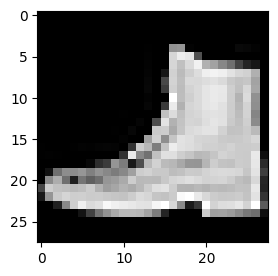

9


In [27]:
# 이미지를 시각화
# batch_size=64라서 0~63번 index중에 한장을 선택해서 시각화
import random

idx = random.randint(0,63)
plt.figure(figsize=(3,3))
plt.imshow(images[idx].squeeze(), cmap='gray')
plt.show()
print(labels[idx].item())

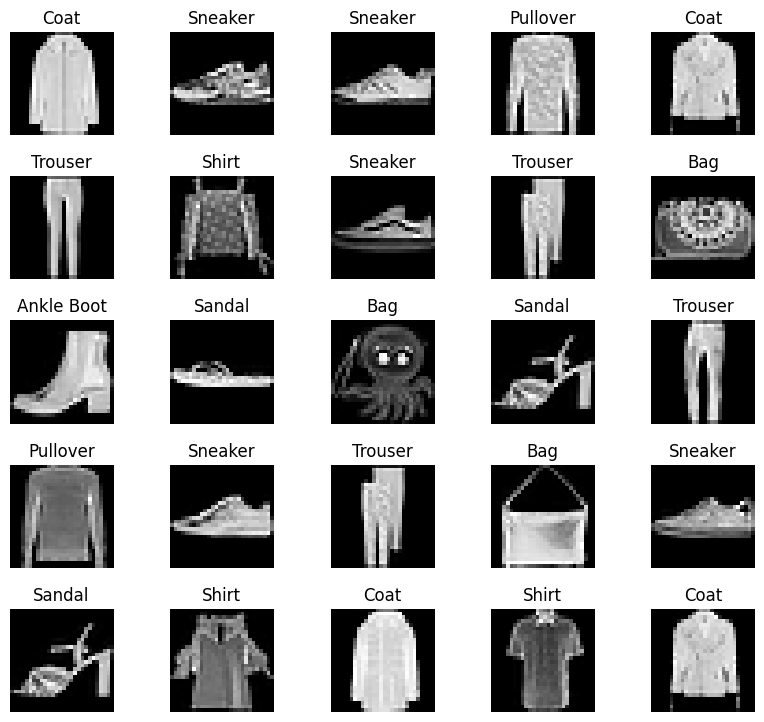

In [28]:
# nxn으로 이미지를 출력
n = 5

fig = plt.figure(figsize=(10, 10))

for i in range(n * n):
    idx = random.randint(0, 63)
    plt.subplot(n, n, i + 1)
    plt.imshow(images[idx].squeeze(), cmap='gray')
    plt.title(labels_map[labels[idx].item()])
    plt.axis('off')

# 하단 공간을 늘리기 위해 추가
plt.subplots_adjust(hspace=0.4, bottom=0.2)

plt.show()

In [29]:
from collections import Counter

labels = training_data.targets  # train_dataset.targets에 라벨 정보가 저장됨


# 고유한 클래스와 갯수 확인
class_count = Counter(labels.numpy())
num_classes = len(class_count)

print(f"MNIST 데이터셋의 클래스 수: {num_classes}")
print(f"각 클래스별 이미지 개수: {class_count}")

MNIST 데이터셋의 클래스 수: 10
각 클래스별 이미지 개수: Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})


In [30]:
# 신경망을 구성
# 신경망 모델 정의
inputNode = 28 * 28 # 이미지의 픽셀 갯수
hiddenNode1 = 512
hiddenNode2 = 256
outputNode = 10 #(0~9)

import torch.nn as nn
import torch.nn.functional as F

# 신경망 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # 입력 레이어 -> 첫 번째 중간 레이어
        self.fc2 = nn.Linear(512, 256)      # 첫 번째 중간 레이어 -> 두 번째 중간 레이어
        self.fc3 = nn.Linear(256, 10)       # 두 번째 중간 레이어 -> 출력 레이어 (10개 클래스)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 입력 이미지를 일렬로 펴서 28*28=784 크기의 벡터로 변환
        x = F.relu(self.fc1(x))  # 첫 번째 중간 레이어에서 ReLU 활성화 함수 적용
        x = F.relu(self.fc2(x))  # 두 번째 중간 레이어에서 ReLU 활성화 함수 적용
        x = self.fc3(x)          # 출력 레이어
        return x

In [31]:
lr = 0.001

# 훈련
# 가속을 위해 신경망을 GPU에서 구성
model = Net().to(device)

# 다중 분류를 위한 손실계산 함수
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [32]:
train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []

In [33]:
def train(model, train_loader, loss_fn, optimizer):
    train_correct = 0
    train_total = 0
    
    # 신경망의 모드를 훈련모드로 설정
    model.train()
    
    # 매 epoch마다 업데이트 되는 loss를 누적하는 변수
    train_loss = 0.0

    # batch 사이즈 만큼 이미지와 레이블을 가져옴
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 기울기 0으로 초기화
        optimizer.zero_grad()

        # 이미지로 추론해서 예측값 출력
        y_pred = model(images)

        # 손실값 계산 
        loss = loss_fn(y_pred, labels)

        # 오차 역전파법으로 경사하강법 기울기 구하기
        loss.backward()

        # 실제 W, b값 업데이트 하기
        optimizer.step() # W_new = W_old - lr * grad(w)

        _, predicted = torch.max(y_pred.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # loss 값 누적하기
        train_loss += loss.item()

    train_loss_list.append(train_loss)
    train_acc = (train_correct / train_total) * 100
    train_acc_list.append(train_acc)
    return train_loss

In [34]:
def valid(model, valid_loader, loss_fn):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    # 기울기를 구하지 않는다.
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            y_pred = model(images)
            loss = loss_fn(y_pred, labels)
            valid_loss += loss.item()
            logit, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    valid_loss_list.append(valid_loss)
    accuracy = (correct / total) * 100
    valid_acc_list.append(accuracy)
    return valid_loss, accuracy

In [35]:
epochs = 10
for epoch in range(epochs):
    # 매 epoch마다 parameter(가중치) 학습
    train_loss = train(model, train_loader, loss_fn, optimizer)
    
    # 매 epoch마다 loss, 값을 출력
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader)}")

    valid_loss, valid_acc = valid(model, valid_loader, loss_fn)

    print(f"Valid Loss: {valid_loss / len(valid_loader)}, Accuray: {valid_acc}%")

Epoch 1/10, Train Loss: 0.5193458034197489
Valid Loss: 0.4065517705488712, Accuray: 84.88333333333333%
Epoch 2/10, Train Loss: 0.3708153553803762
Valid Loss: 0.35420111170474516, Accuray: 87.05833333333334%
Epoch 3/10, Train Loss: 0.33292874646186826
Valid Loss: 0.34371893258487923, Accuray: 87.65833333333333%
Epoch 4/10, Train Loss: 0.3106888195574284
Valid Loss: 0.3418302574848875, Accuray: 87.7%
Epoch 5/10, Train Loss: 0.291345041145881
Valid Loss: 0.31975020539570365, Accuray: 88.16666666666667%
Epoch 6/10, Train Loss: 0.2738118480741978
Valid Loss: 0.3102211968458079, Accuray: 88.98333333333333%
Epoch 7/10, Train Loss: 0.2608848954339822
Valid Loss: 0.2962453306276113, Accuray: 89.26666666666667%
Epoch 8/10, Train Loss: 0.24714778038362661
Valid Loss: 0.30861478074988785, Accuray: 88.94999999999999%
Epoch 9/10, Train Loss: 0.23674337951342264
Valid Loss: 0.30012432248034376, Accuray: 89.325%
Epoch 10/10, Train Loss: 0.22674931333462398
Valid Loss: 0.2941063678565812, Accuray: 89.4

In [36]:
len(train_loss_list)

10

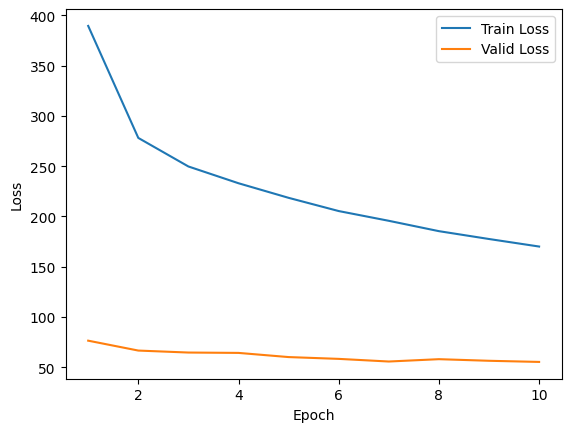

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1,epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1,epochs+1), valid_loss_list, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

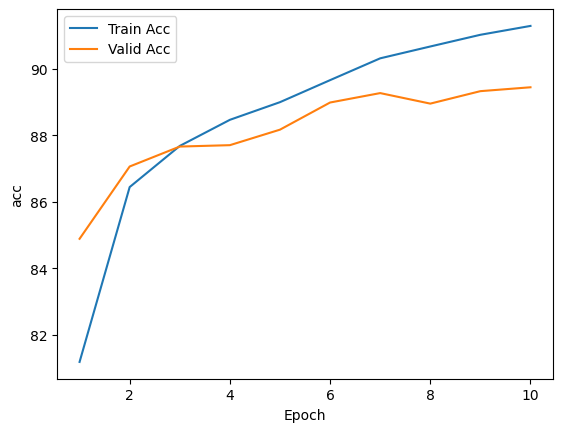

In [38]:
plt.figure()
plt.plot(range(1,epochs+1), train_acc_list, label='Train Acc')
plt.plot(range(1,epochs+1), valid_acc_list, label='Valid Acc')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.legend()
plt.show()